In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
import struct as st


Mounted at /content/drive


In [ ]:
def read_data(filename):
    file = gzip.open(filename,'rb')
    file.seek(0)
    magic_number = st.unpack('>4B',file.read(4)) # read magic number
    number_of_images = st.unpack('>I',file.read(4))[0] # read number of images
    number_of_rows = st.unpack('>I',file.read(4))[0] #read number of rows
    number_of_columns = st.unpack('>I',file.read(4))[0] #read number of column
    with gzip.open(filename) as file_stream:
        file_stream.read(16)
        buf = file_stream.read(number_of_rows * number_of_columns * number_of_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(number_of_images, number_of_rows,number_of_columns)
        return data

In [ ]:
train_data = read_data('/content/train-images-idx3-ubyte.gz')
test_data = read_data('/content/t10k-images-idx3-ubyte.gz')

In [ ]:
def read_labels(filename):
    file = gzip.open(filename,'rb')
    file.seek(0)
    magic_number = st.unpack('>4B',file.read(4)) # read magic number
    number_of_iteams = st.unpack('>I',file.read(4))[0] # read number of images
    with gzip.open(filename) as file_stream:
        file_stream.read(8)
        buf = file_stream.read(number_of_iteams)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [ ]:
train_labels = read_labels('/content/train-labels-idx1-ubyte.gz')
test_labels = read_labels('/content/t10k-labels-idx1-ubyte.gz')

In [ ]:
# Create dictionary of target classes
label_dict = {
 0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
}

In [ ]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [ ]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

In [ ]:
batch_size = 128
epochs = 25
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10
n_inputs = train_data.shape[1]

In [ ]:


#encoder
conv1 = Conv2D(32, (2, 2), activation='relu', padding='valid',strides=2)(input_img) # 14 x 14 x 32
conv2 = Conv2D(64, (2, 2), activation='relu', padding='valid',strides=2)(conv1) # 7 x 7 x 64
conv3 = Conv2D(128, (2, 2), activation='relu', padding='valid',strides=2)(conv2) # 3 x 3 x 128


# bottleneck
flatten = Flatten()(conv3)
encoded = Dense(int(10), activation='relu')(flatten)
decoded = Dense(units = 3*3*128, activation='relu')(encoded)
reshape = Reshape(target_shape = (3,3,128))(decoded)  # 3 x 3 x 128


#decoder
conv4 = Conv2DTranspose(64, (3, 3), activation='relu', padding='valid',strides=2)(reshape) # 7 x 7 x 64
conv5 = Conv2DTranspose(32, (2, 2), activation='relu', padding='valid',strides=2)(conv4) # 14 x 14 x 32
conv6 = Conv2DTranspose(1, (2, 2), activation='sigmoid', padding='valid',strides=2)(conv5) # 28 x 28 x 1


decoded = conv6

In [ ]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          8256      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         32896     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                11530     
_________________________________________________________________
dense_1 (Dense)              (None, 1152)              12672 

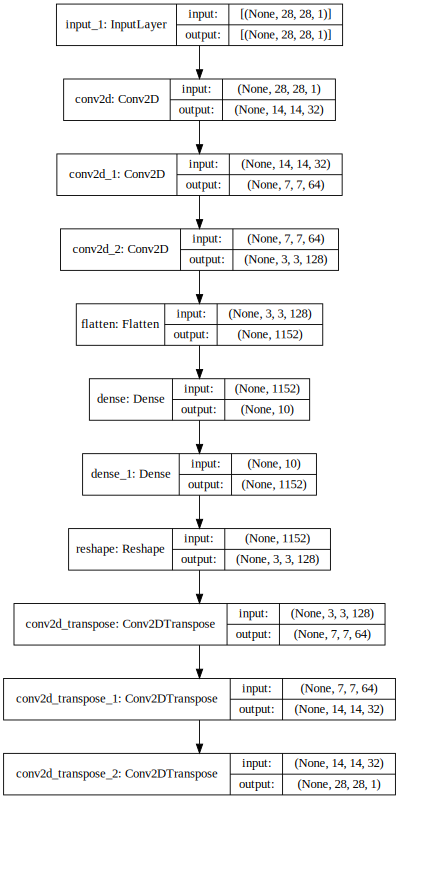

In [ ]:
autoencoder.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder,show_shapes=True,dpi=65).create(prog='dot', format='svg'))

In [ ]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/25
375/375 [==============================] - 10s 6ms/step - loss: 0.0859 - val_loss: 0.0368
Epoch 2/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0345 - val_loss: 0.0291
Epoch 3/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0283 - val_loss: 0.0260
Epoch 4/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0255 - val_loss: 0.0250
Epoch 5/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0236 - val_loss: 0.0241
Epoch 6/25
375/375 [==============================] - 2s 4ms/step - loss: 0.0223 - val_loss: 0.0218
Epoch 7/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0215 - val_loss: 0.0204
Epoch 8/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0200 - val_loss: 0.0195
Epoch 9/25
375/375 [==============================] - 2s 4ms/step - loss: 0.0190 - val_loss: 0.0196
Epoch 10/25
375/375 [==============================] - 2s 4ms/step - loss: 0.0183 - val_loss: 0.018

In [ ]:
# define an encoder model (without the decoder)
encoder = Model(inputs=input_img, outputs=encoded)

In [ ]:
# encode the train data
X_train_encode = encoder.predict(train_data)
X_test_encode = encoder.predict(test_data)

In [ ]:
print(X_train_encode.shape)
print(X_test_encode.shape)
print(train_data.shape)

(60000, 10)
(10000, 10)
(60000, 28, 28, 1)


In [ ]:
print(train_labels[:10])

[5 0 4 1 9 2 1 3 1 4]


In [ ]:
print(X_train_encode[10])
print('---------------------')
print(X_train_encode[25])

[18.512648  15.34258   11.215647  11.55224   16.752487  16.498478
  3.5095491 14.963499  10.041497  12.0304575]
---------------------
[25.182013  2.298097 17.492075  7.651996 22.419945 10.946219  8.140604
 13.400991 13.790668 13.025706]


In [ ]:
def normalize(x):
    return (25500*(x - np.min(x))/np.ptp(x)).astype(int)

In [ ]:
print(normalize(X_train_encode[10]))
print('---------------------')
print(normalize(X_train_encode[25]))

[25500 20111 13097 13669 22508 22076     0 19467 11102 14482]
---------------------
[25500     0 16930  5965 22422  9636  6510 12372 12806 11953]


Na filaksoume tis nees eikones se file gia na tis diavasoume meso tis c++

In [ ]:

def saveNewImages(compressedImgs,filename):
  f = open(filename,"w")
  #The first line will contain the number of images
  f.write(str(len(compressedImgs)) + "\n")
  #The second line will contain the number of rows
  f.write(str(len(compressedImgs[0])) + "\n")
  #The third line will contain the number of columns
  try:
    f.write(str(len(compressedImgs[0][0])) + "\n")
  except:
    f.write("1\n")
  #For the rest of the file each line contains the pixels of an image
  #seperated by spaces
  for image in compressedImgs:
    for pixel in image:
      strPixel = str(pixel)
      strPixel = strPixel.strip('[')
      strPixel = strPixel.strip(']')
      f.write(strPixel + " ")
    f.write("\n")
  f.close()
saveNewImages(normalize(X_train_encode),"trainCompressed")
saveNewImages(normalize(X_test_encode),"testCompressed")

In [ ]:
def saveLabels(labels,filename):
  f = open(filename,"w")
  #First line will contain the number of labels
  f.write(str(len(labels)) + "\n")
  #For the rest of the file each line contains the label of the image
  for label in labels:
    f.write(str(label) + "\n")
  f.close()

saveLabels(train_labels,"trainLabels")
saveLabels(test_labels,"testLabels")